In [4]:
import crocoddyl
import numpy as np
import example_robot_data
import pinocchio as pin

from action_model import DifferentialFwdKinematics

talos_arm = example_robot_data.load('talos_arm')
robot_model = talos_arm.model # getting the Pinocchio model

# Defining a initial state
q0 = np.array([0.173046, 1., -0.52366, 0., 0., 0.1, -0.005])
x0 = np.concatenate([q0, np.zeros(talos_arm.model.nv)])

In [37]:
# Create the cost functions
target = np.array([0.5, 0.5, 0.0])
Mref = crocoddyl.FrameTranslation(robot_model.getFrameId("gripper_left_joint"), target)
state = crocoddyl.StateMultibody(robot_model)
goalTrackingCost = crocoddyl.CostModelFrameTranslation(state, Mref)
xRegCost = crocoddyl.CostModelState(state)
uRegCost = crocoddyl.CostModelControl(state)

# Create cost model per each action model
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("gripperPose", goalTrackingCost, 1e2)
runningCostModel.addCost("stateReg", xRegCost, 1e-3)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-3)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 1e5)
terminalCostModel.addCost("stateReg", xRegCost, 1e-3)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-5)

# Running and terminal action models
DT = 1e-3
actuationModel = crocoddyl.ActuationModelFull(state)
runningModel = crocoddyl.IntegratedActionModelEuler(
    DifferentialFwdKinematics(state, runningCostModel), DT)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    DifferentialFwdKinematics(state,terminalCostModel), 0.)

In [38]:
# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 250
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

In [39]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()

# Using the meshcat displayer, you could enable gepetto viewer for nicer view
# display = crocoddyl.GepettoDisplay(talos_arm, 4, 4)
display = crocoddyl.MeshcatDisplay(talos_arm, 4, 4, False)
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose(),
                  crocoddyl.CallbackDisplay(display)])
# Emdebbed meshcat in this cell
display.robot.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [40]:
# Solving it with the DDP algorithm
ddp.solve()

# Printing the reached position
frame_idx = talos_arm.model.getFrameId("gripper_left_joint")
xT = ddp.xs[-1]
qT = xT[:talos_arm.model.nq]
print(talos_arm.framePlacement(qT, frame_idx))



  R =
 -0.0392466    0.348738   -0.936398
    0.12063   -0.928613   -0.350895
  -0.991921   -0.126729 -0.00562331
  p =   0.366814     0.4819 0.00394692



In [41]:
display.displayFromSolver(ddp, 1000)

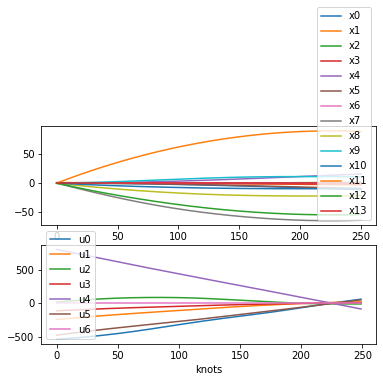

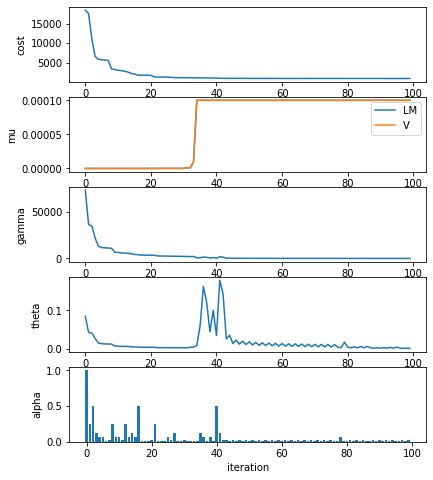

In [42]:
%matplotlib inline
# # Plotting the solution and the DDP convergence
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps)

# Visualizing the solution in gepetto-viewer
display.displayFromSolver(ddp)

